# つくりながら学ぶ！深層強化学習 PyTorchによる実践プログラミング

## 迷路問題

### 迷路の実装
`Makie.jl` の OpenGL 実装である `GLMakie.jl` をプロットフレームワークとして利用する

- Documents
    - [Figure](https://makie.juliaplots.org/v0.17.3/documentation/figure/)
    - [Axis](https://makie.juliaplots.org/v0.17.3/examples/blocks/axis/index.html)
    - [Plotting functions > lines](https://makie.juliaplots.org/v0.17.3/examples/plotting_functions/lines/)
    - [Plotting functions > text](https://makie.juliaplots.org/v0.17.3/examples/plotting_functions/text/)

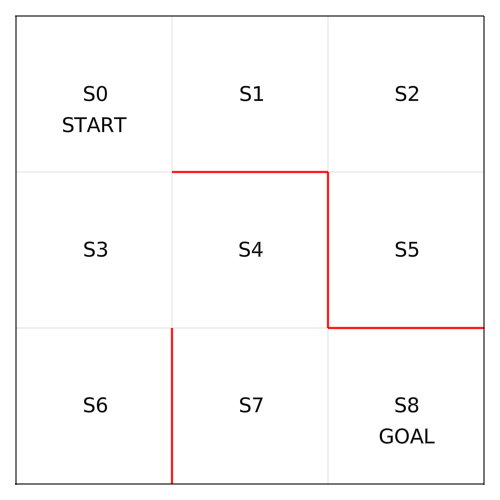

In [1]:
# 関数の中身などを再起動不要で修正できるように Revise.jl を読み込んでおく
using Revise
using GLMakie

# 500x500 の Figure 作成
fig = Figure(resolution = (500, 500))

# Figure grid layout (1, 1) を描画対象にする
plt = fig[1, 1]
ax = Axis(plt) # 軸は必ず作成する必要がある (少し時間がかかる)

# 描画範囲の設定
xlims!(ax, 0, 3)
ylims!(ax, 0, 3)

# 軸の目盛りを非表示化
## グリッド線は表示する (grid = false)
hidedecorations!(ax, grid = false)

# 赤い壁を描画
lines!(plt, [1, 1], [0, 1], color = :red, linewidth = 2)
lines!(plt, [1, 2], [2, 2], color = :red, linewidth = 2)
lines!(plt, [2, 2], [2, 1], color = :red, linewidth = 2)
lines!(plt, [2, 3], [1, 1], color = :red, linewidth = 2)

# 状態を示す文字 S0 ~ S8 を描画
text!(plt, "S0", position = (0.5, 2.5), size = 14, align = (:center, :center))
text!(plt, "S1", position = (1.5, 2.5), size = 14, align = (:center, :center))
text!(plt, "S2", position = (2.5, 2.5), size = 14, align = (:center, :center))
text!(plt, "S3", position = (0.5, 1.5), size = 14, align = (:center, :center))
text!(plt, "S4", position = (1.5, 1.5), size = 14, align = (:center, :center))
text!(plt, "S5", position = (2.5, 1.5), size = 14, align = (:center, :center))
text!(plt, "S6", position = (0.5, 0.5), size = 14, align = (:center, :center))
text!(plt, "S7", position = (1.5, 0.5), size = 14, align = (:center, :center))
text!(plt, "S8", position = (2.5, 0.5), size = 14, align = (:center, :center))
text!(plt, "START", position = (0.5, 2.3), size = 14, align = (:center, :center))
text!(plt, "GOAL", position = (2.5, 0.3), size = 14, align = (:center, :center))

fig

### エージェントの実装
緑丸で示されたエージェントが、迷路内をランダムに移動してゴールを目指す部分を実装する

強化学習では、エージェントがどのように行動するかを定めたルールのことを **方策 (Policy)** と呼ぶ

方策は $\pi_\theta(s, a)$ で表現され、「状態 $s$ のときに行動 $a$ を採用する確率はパラメータ $\theta$ で決まる方策 $\pi$ に従う」ことを表す

迷路問題の場合、状態 $s$ はエージェントが迷路内のどの位置にいるかを示す

今回の場合、`S0` ～ `S8` まで9つの状態がある

行動 $a$ は、各状態においてエージェントが実行できる行動を示す

迷路問題の場合は、上、右、下、左へ移動するという4種類の行動がある（ただし、赤い壁がある方向へは移動できない）

方策 $\pi$ の表現方法は様々なものがあり、関数を使うこともあれば、ニューラルネットワークで表現することもある

最も簡単な表現は **表形式方策 (Tabler Policy)** であり、行が状態 $s$ を、列が行動 $a$ を示し、表の値が行動の採用確率を示す

今回の迷路問題のように、状態も行動もそれほど数が多くない場合は表形式方策を利用するのがわかりやすい

パラメータ $\theta$ は方策 $\pi$ に関するパラメータであり、ニューラルネットワークの場合は素子間結合パラメータなどに対応する

今回の場合は、各状態 $s$ において行動 $a$ を採用する確率に変換される値（行動の重み）が $\theta$ となる

In [2]:
"""
    theta_0::Matrix{Number} (8x4)

初期方策を決定するパラメータ theta_0

- 行: 状態 S0 ~ S7 (S8 はゴールのため方策なしで良い)
- 列: 行動 ↑, →, ↓, ← (ただし赤い壁への移動は不可)
- 各値: 行動の重み θ
    - 初期値はすべての行動の重みを 1.0 と設定
    - 移動不可の行動は欠損値 (NaN) を設定
"""
theta_0 = [
    NaN  1.0  1.0  NaN  # S0での移動可能方向: →, ↓
    NaN  1.0  NaN  1.0  # S1での移動可能方向: →, ←
    NaN  1.0  1.0  1.0  # S2での移動可能方向: ↓, ←
    1.0  1.0  1.0  NaN  # S3での移動可能方向: ↑, →, ↓
    NaN  NaN  1.0  1.0  # S4での移動可能方向: ↓, ←
    1.0  NaN  NaN  NaN  # S5での移動可能方向: ↑
    1.0  NaN  NaN  NaN  # S6での移動可能方向: ↑
    1.0  1.0  NaN  NaN  # S7での移動可能方向: ↑, →
]

theta_0

8×4 Matrix{Float64}:
 NaN      1.0    1.0  NaN
 NaN      1.0  NaN      1.0
 NaN      1.0    1.0    1.0
   1.0    1.0    1.0  NaN
 NaN    NaN      1.0    1.0
   1.0  NaN    NaN    NaN
   1.0  NaN    NaN    NaN
   1.0    1.0  NaN    NaN

In [3]:
using NaNStatistics

"""
    pi_theta(theta::Matrix{Number}) = pi::Matrix{Number} (8x4)

方策パラメータ θ を行動方策 π に変換する関数

- 行動の重み θ から、行動の採用確率 π_θ に変換する
- 例: S0 [NaN 1.0 1.0 NaN] の場合
    - 行動の採用確率は [0.0 0.5 0.5 0.0] となる
"""
pi_theta(theta::Matrix) =
    # 各値をその行での割合 (値 / その行の合計値) に変換
    ## NaN 値を無視して合計を出すには NaNStatistics.nansum を使うと良い
    theta ./ nansum(theta, dims = 2) |>
        # NaN 値を 0.0 に変換する
        theta -> map(theta) do t isnan(t) ? 0.0 : t end

# π_(θ_0)
pi_0 = pi_theta(theta_0)
pi_0

8×4 Matrix{Float64}:
 0.0       0.5       0.5       0.0
 0.0       0.5       0.0       0.5
 0.0       0.333333  0.333333  0.333333
 0.333333  0.333333  0.333333  0.0
 0.0       0.0       0.5       0.5
 1.0       0.0       0.0       0.0
 1.0       0.0       0.0       0.0
 0.5       0.5       0.0       0.0

In [4]:
using Distributions

"""
    next_state(pi::Matrix{Number}, state::Int) = state_next::Int

1step 後の状態 s を求める関数

- `pi::Matrix{Number}`: 方策 π
- `state::Int`: 現在の状態 1..8
    - 1: S0, 2: S1, ... 8: S7
"""
next_state(pi::Matrix{<:Number}, state::Int) = begin
    directions = [:up, :right, :down, :left]

    # 行動を決定
    ## Distributions.wsample(samples::Vector, weights::Vector) = choiced_sample
    ### samples の中から任意の値を1つ選択する。ただしその選択確率は weights で定められた重みによって決められる
    direction_next = wsample(directions, pi[state, :])

    # 状態遷移
    # - 上: 状態 - 3
    # - 右: 状態 + 1
    # - 下: 状態 + 3
    # - 左: 状態 - 1
    state_transitions = Dict(
        :up    => -3,
        :right => +1,
        :down  => +3,
        :left  => -1,
    )
    state_next = state + state_transitions[direction_next]
end

# 状態: S0 → 状態: ?
next_state(pi_0, 1)

2

In [5]:
using Test

"""
test: 状態 S0 → 状態 ?

- 状態 S0 での方策 π_0[S0] は [0.0, 0.5, 0.5, 0.0]
    - => 取り得る行動は → or ↓
    - => 行動後の状態は S1 or S3
"""
# 100回施行して問題ないことを確認
@testset "状態 S0 → 状態 S1 | S3" begin
    for _ = 1:100
        s_next = next_state(pi_0, 1)
        @test s_next === 2 || s_next === 4
    end
end

Test Summary:      | Pass  Total
状態 S0 → 状態 S1 | S3 |  100    100


Test.DefaultTestSet("状態 S0 → 状態 S1 | S3", Any[], 100, false, false)

In [6]:
"""
    maze(pi::Matrix{Number}) = state_history::Vector{Int}

迷路内をエージェントがゴールするまで移動させる関数

ゴールするまでにエージェントが通った状態の軌跡 state_history を返す
"""
maze(pi::Matrix) = begin
    # スタート地点: S0, ゴール地点: S8
    start, goal = 1, 9

    state::Int = start # 状態: 初期値 = S0
    state_history::Vector{Int} = [1] # エージェントの移動記録

    # ゴールするまで step を繰り返す
    while state !== goal
        state = next_state(pi, state)
        push!(state_history, state)
    end

    state_history
end

state_history = maze(pi_0)
state_history

25-element Vector{Int64}:
 1
 4
 1
 4
 7
 4
 7
 4
 1
 4
 1
 2
 1
 4
 7
 4
 7
 4
 5
 8
 5
 4
 5
 8
 9

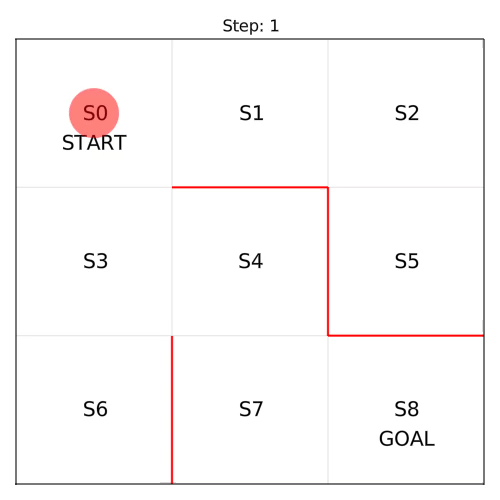

In [7]:
"""
エージェントの移動記録を動画化する

https://makie.juliaplots.org/v0.17.3/documentation/animation/

- エージェント:
    - 赤色半透明のドットで表現: `scatter!(Point2f(x, y); color = (:red, 0.5), markersize = 50)`
    - フレームごとに変化する値は `Makie.Observable()` で定義可能
- アニメーション:
    - `Makie.record(animation_func, fig, save_filename, frames)` で作成可能
"""
# 状態 => プロット位置マッピング
state_positions = [
    Point2f(0.5, 2.5), # S0
    Point2f(1.5, 2.5), # S1
    Point2f(2.5, 2.5), # S2
    Point2f(0.5, 1.5), # S3
    Point2f(1.5, 1.5), # S4
    Point2f(2.5, 1.5), # S5
    Point2f(0.5, 0.5), # S6
    Point2f(1.5, 0.5), # S7
    Point2f(2.5, 0.5), # S8
]

# エージェント: 初期プロット
agent_pos = Observable(state_positions[1])
scatter!(plt, agent_pos, color = (:red, 0.5), markersize = 50)

# 01-maze.gif にアニメーション保存
record(fig, "img/01_01-maze.gif", 1:length(state_history);
    # state_history::Vector{状態::Int} を10秒でアニメーションさせるように framerate 設定
    framerate = ceil(Int, length(state_history) / 10)
) do frame
    # エージェント位置更新
    agent_pos[] = state_positions[state_history[frame]]

    # プロットタイトル更新
    ax.title = "Step: $frame"
end

display("image/gif", read("img/01_01-maze.gif"))

今回の場合、エージェントが進行可能なすべての方向に同じ確率で動くように方策 $\pi_\theta(s, a)$ を定義している

そのため、エージェントは真っ直ぐゴールに向かうのではなく、ランダムにさまよいながらゴールに向かっている様子が見て取れる

次回からは、エージェントが真っ直ぐゴールに向かうように強化学習の実装を行っていく

---

[今回の実装モジュール](./01_01-maze_module.jl)

```julia
include("01_01-maze_module.jl")
using .Maze

state_history = maze(pi_theta(theta_0))
save_anim("01_01-maze.gif", state_history)
```